<a href="https://colab.research.google.com/github/Sahilo6/redHanded-ai-ml/blob/main/RedHanded_AIML_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup: Install and import required libraries for anomaly detection

!pip install pyod scikit-learn pandas numpy matplotlib seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 6.6 MB/s eta 0:00:00
Libraries loaded successfully!


In [2]:
# Generate synthetic blockchain-verified event logs with normal and anomalous user behavior

np.random.seed(42)

def generate_blockchain_logs(n_users=50, n_blocks=100):
    """Generate synthetic blockchain event logs"""

    logs = []
    block_id = 1

    for user_id in range(1, n_users + 1):
        n_events = np.random.randint(10, 30) if user_id != 15 else 80  # User 15 is anomalous

        for _ in range(n_events):
            login_success = np.random.choice([True, False], p=[0.95, 0.05])
            is_admin_action = np.random.choice([True, False], p=[0.1, 0.9])
            time_gap = np.random.exponential(scale=300)  # avg 5 min gaps

            if user_id == 15:
                login_success = np.random.choice([True, False], p=[0.6, 0.4])
                is_admin_action = np.random.choice([True, False], p=[0.4, 0.6])
                time_gap = np.random.exponential(scale=30)

            logs.append({
                'block_id': block_id,
                'user_id': f'user_{user_id}',
                'timestamp': datetime.now() - timedelta(seconds=time_gap * _),
                'login_success': login_success,
                'is_admin_action': is_admin_action
            })
            block_id += 1

    return pd.DataFrame(logs)

df = generate_blockchain_logs()
print(f"Generated {len(df)} blockchain-verified events")
print(f"Tracking {df['user_id'].nunique()} users")
df.head(10)

Generated 1032 blockchain-verified events
Tracking 50 users


,block_id,user_id,timestamp,login_success,is_admin_action
0,1,user_1,2026-02-07 16:04:30.254347,True,False
1,2,user_1,2026-02-07 16:03:58.654664,True,False
2,3,user_1,2026-02-07 16:02:57.757356,True,False
3,4,user_1,2026-02-07 15:45:18.137866,True,True
4,5,user_1,2026-02-07 14:27:24.117194,True,True
5,6,user_1,2026-02-07 16:04:19.617709,True,False
6,7,user_1,2026-02-07 15:49:11.185777,True,False
7,8,user_1,2026-02-07 15:55:13.817112,True,False
8,9,user_1,2026-02-07 15:45:13.419838,True,False
9,10,user_1,2026-02-07 14:36:02.899434,False,False


In [3]:
# Extract behavioral features from raw logs: login frequency, time gaps, fail/success ratio, admin bursts

def extract_features(df):
    """Calculate anomaly detection features"""

    features = df.groupby('user_id').agg({
        'block_id': 'count',
        'login_success': ['sum', 'mean'],
        'is_admin_action': 'sum',
        'timestamp': lambda x: (x.max() - x.min()).total_seconds()
    }).reset_index()

    features.columns = ['user_id', 'login_frequency', 'success_count',
                        'success_ratio', 'admin_actions', 'duration_seconds']

    time_gaps = df.groupby('user_id')['timestamp'].apply(
        lambda x: x.sort_values().diff().dt.total_seconds().mean()
    ).reset_index()
    time_gaps.columns = ['user_id', 'avg_time_gap']

    features = features.merge(time_gaps, on='user_id')

    features['fail_success_ratio'] = (features['login_frequency'] - features['success_count']) / (features['success_count'] + 1)

    features['admin_burst_rate'] = (features['admin_actions'] / (features['duration_seconds'] / 3600)).fillna(0)

    return features

features_df = extract_features(df)
print("Extracted Features:")
print(features_df.describe())
features_df.head(10)

Extracted Features:
       login_frequency  success_count  success_ratio  admin_actions  \
count        50.000000      50.000000      50.000000      50.000000   
mean         20.640000      18.720000       0.924786       2.780000   
std          10.173515       7.001574       0.067116       4.468895   
min          12.000000      10.000000       0.650000       0.000000   
25%          15.000000      13.250000       0.890351       1.000000   
50%          18.500000      17.000000       0.941176       2.000000   
75%          25.000000      23.500000       0.961538       3.000000   
max          80.000000      52.000000       1.000000      32.000000   

       duration_seconds  avg_time_gap  fail_success_ratio  admin_burst_rate  
count         50.000000     50.000000           50.000000         50.000000  
mean       12170.753488    627.422453            0.083181          1.080765  
std         8507.459451    346.799225            0.089057          2.327782  
min         2689.879886     

,user_id,login_frequency,success_count,success_ratio,admin_actions,duration_seconds,avg_time_gap,fail_success_ratio,admin_burst_rate
0,user_1,16,15,0.937500,2,6984.623185,465.641546,0.062500,1.030836
1,user_10,21,20,0.952381,5,10680.341272,534.017064,0.047619,1.685339
2,user_11,27,26,0.962963,1,17594.978722,676.729951,0.037037,0.204604
3,user_12,23,21,0.913043,5,9530.847194,433.220327,0.090909,1.888604
4,user_13,15,13,0.866667,0,5597.071959,399.790854,0.142857,0.000000
5,user_14,23,22,0.956522,2,12049.106969,547.686680,0.043478,0.597555
6,user_15,80,52,0.650000,32,6862.837870,86.871365,0.528302,16.786059
7,user_16,21,18,0.857143,3,13164.878652,658.243933,0.157895,0.820365
8,user_17,21,20,0.952381,2,8985.107971,449.255399,0.047619,0.801326
9,user_18,27,24,0.888889,5,14741.461984,566.979307,0.120000,1.221046


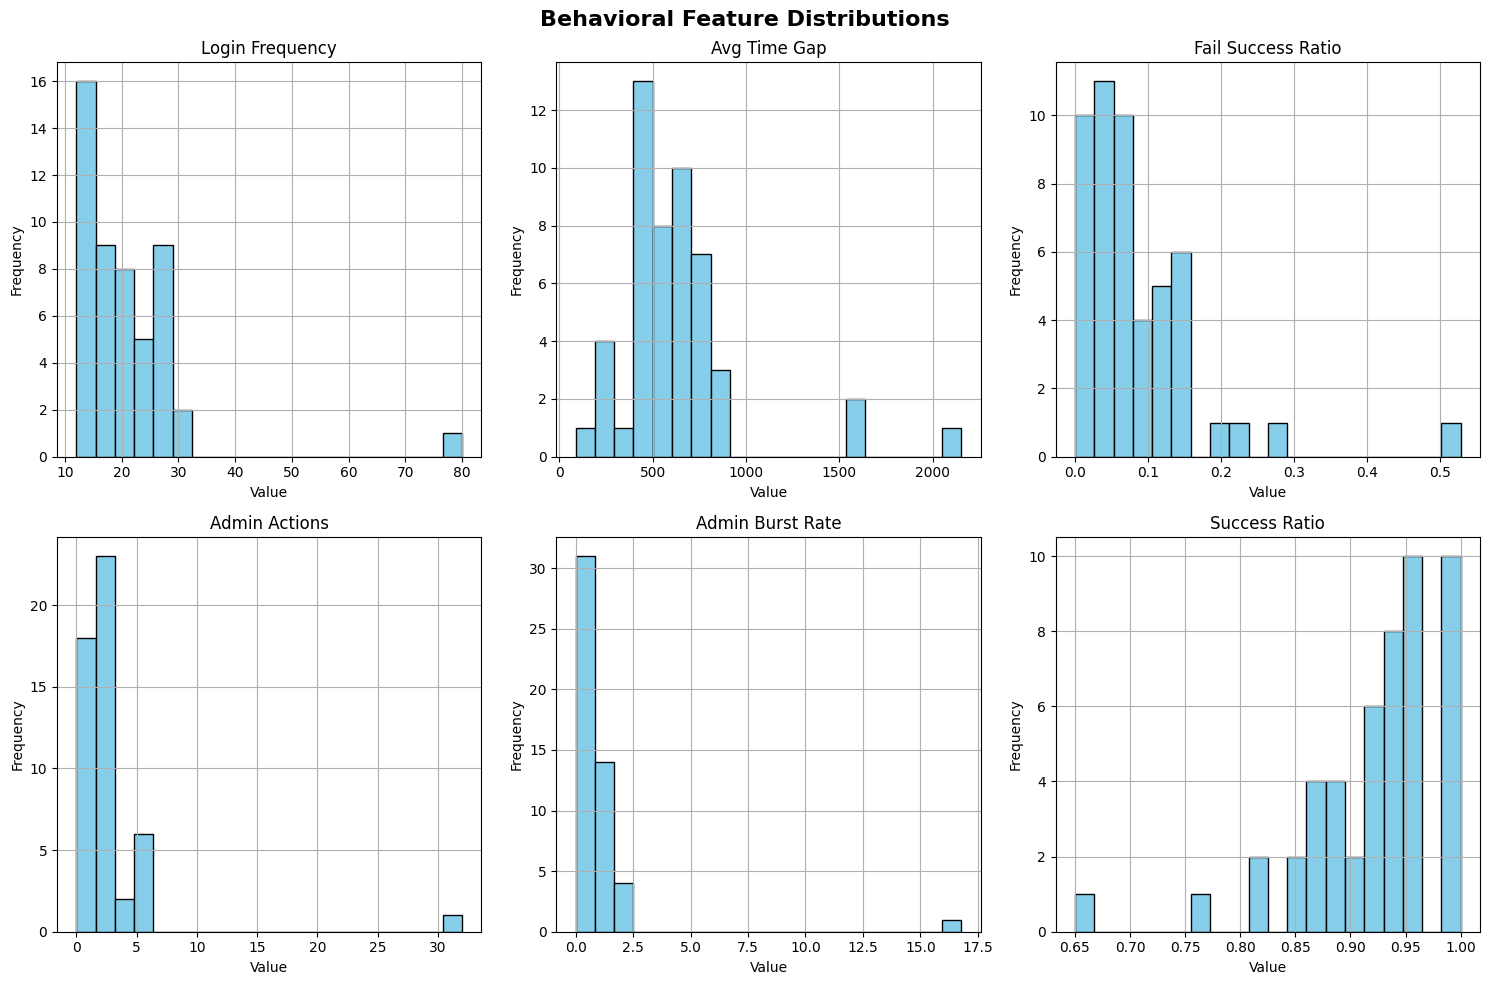

In [4]:
# Visualize the distribution of behavioral features to identify potential outliers

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Behavioral Feature Distributions', fontsize=16, fontweight='bold')

features_to_plot = ['login_frequency', 'avg_time_gap', 'fail_success_ratio',
                    'admin_actions', 'admin_burst_rate', 'success_ratio']

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx // 3, idx % 3]
    features_df[feature].hist(bins=20, ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(feature.replace('_', ' ').title())
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [5]:
# Train Isolation Forest model to detect anomalies by isolating outliers in feature space

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

feature_cols = ['login_frequency', 'avg_time_gap', 'fail_success_ratio',
                'admin_actions', 'admin_burst_rate', 'success_ratio']

X = features_df[feature_cols].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso_forest = IsolationForest(
    contamination=0.1,
    random_state=42,
    n_estimators=100
)

features_df['anomaly_if'] = iso_forest.fit_predict(X_scaled)
features_df['anomaly_score_if'] = iso_forest.score_samples(X_scaled)

anomalies_if = features_df[features_df['anomaly_if'] == -1].sort_values('anomaly_score_if')

print(f"Isolation Forest detected {len(anomalies_if)} anomalies:")
print(anomalies_if[['user_id', 'login_frequency', 'fail_success_ratio',
                     'admin_burst_rate', 'anomaly_score_if']])

Isolation Forest detected 5 anomalies:
    user_id  login_frequency  fail_success_ratio  admin_burst_rate  \
6   user_15               80            0.528302         16.786059   
44   user_5               13            0.272727          0.000000   
36  user_42               16            0.000000          0.111421   
33   user_4               29            0.153846          0.082492   
49   user_9               17            0.200000          1.557317   

    anomaly_score_if  
6          -0.853055  
44         -0.591596  
36         -0.564341  
33         -0.562815  
49         -0.548032  


In [6]:
# Apply Local Outlier Factor (LOF) to detect anomalies based on local density comparison

from pyod.models.lof import LOF

lof = LOF(n_neighbors=20, contamination=0.1)
features_df['anomaly_lof'] = lof.fit_predict(X_scaled)
features_df['anomaly_score_lof'] = lof.decision_scores_

anomalies_lof = features_df[features_df['anomaly_lof'] == 1].sort_values('anomaly_score_lof', ascending=False)

print(f"LOF detected {len(anomalies_lof)} anomalies:")
print(anomalies_lof[['user_id', 'login_frequency', 'admin_actions', 'anomaly_score_lof']].head())

LOF detected 5 anomalies:
    user_id  login_frequency  admin_actions  anomaly_score_lof
6   user_15               80             32           7.749948
36  user_42               16              1           2.921364
17  user_25               26              2           2.007909
33   user_4               29              1           1.975709
44   user_5               13              0           1.893289


In [7]:
# Use HBOS (Histogram-Based Outlier Score) for fast feature-wise anomaly detection

from pyod.models.hbos import HBOS

hbos = HBOS(contamination=0.1)
features_df['anomaly_hbos'] = hbos.fit_predict(X_scaled)
features_df['anomaly_score_hbos'] = hbos.decision_scores_

anomalies_hbos = features_df[features_df['anomaly_hbos'] == 1].sort_values('anomaly_score_hbos', ascending=False)

print(f"HBOS detected {len(anomalies_hbos)} anomalies:")
print(anomalies_hbos[['user_id', 'fail_success_ratio', 'admin_burst_rate', 'anomaly_score_hbos']].head())

HBOS detected 5 anomalies:
    user_id  fail_success_ratio  admin_burst_rate  anomaly_score_hbos
6   user_15            0.528302         16.786059           16.563387
49   user_9            0.200000          1.557317            8.095364
3   user_12            0.090909          1.888604            7.884973
14  user_22            0.217391          0.689062            6.443556
1   user_10            0.047619          1.685339            6.126350


In [18]:
# Apply Elliptic Envelope assuming normal behavior follows a Gaussian distribution

from sklearn.covariance import EllipticEnvelope

elliptic = EllipticEnvelope(contamination=0.15, random_state=42)
features_df['anomaly_elliptic'] = elliptic.fit_predict(X_scaled)

anomalies_elliptic = features_df[features_df['anomaly_elliptic'] == -1]

print(f"Elliptic Envelope detected {len(anomalies_elliptic)} anomalies:")
print(anomalies_elliptic[['user_id', 'login_frequency', 'success_ratio']].head())

Elliptic Envelope detected 8 anomalies:
    user_id  login_frequency  success_ratio
6   user_15               80       0.650000
14  user_22               27       0.814815
18  user_26               12       1.000000
29  user_36               12       1.000000
33   user_4               29       0.862069


In [19]:
# Use Robust PCA to separate normal patterns from sparse anomalies

from pyod.models.pca import PCA as RobustPCA

rpca = RobustPCA(contamination=0.2)
features_df['anomaly_rpca'] = rpca.fit_predict(X_scaled)
features_df['anomaly_score_rpca'] = rpca.decision_scores_

anomalies_rpca = features_df[features_df['anomaly_rpca'] == 1].sort_values('anomaly_score_rpca', ascending=False)

print(f"Robust PCA detected {len(anomalies_rpca)} anomalies:")
print(anomalies_rpca[['user_id', 'admin_actions', 'anomaly_score_rpca']].head())

Robust PCA detected 10 anomalies:
    user_id  admin_actions  anomaly_score_rpca
6   user_15             32        39466.165136
36  user_42              1        14640.846104
44   user_5              0        10494.717245
33   user_4              1        10032.284257
17  user_25              2         9716.762675


Model Comparison:
               Model  Anomalies Detected  Detected user_15
0   Isolation Forest                   5              True
1                LOF                   5              True
2               HBOS                   5              True
3  Elliptic Envelope                   8              True
4         Robust PCA                  10              True


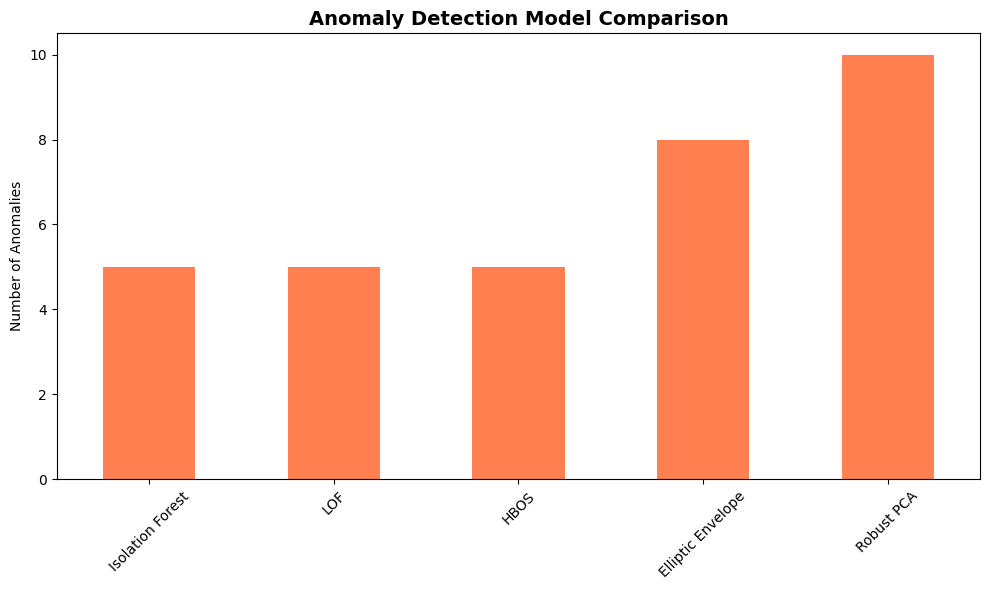

In [20]:
# Compare detection results across all models

comparison = pd.DataFrame({
    'Model': ['Isolation Forest', 'LOF', 'HBOS', 'Elliptic Envelope', 'Robust PCA'],
    'Anomalies Detected': [
        len(anomalies_if),
        len(anomalies_lof),
        len(anomalies_hbos),
        len(anomalies_elliptic),
        len(anomalies_rpca)
    ],
    'Detected user_15': [
        'user_15' in anomalies_if['user_id'].values,
        'user_15' in anomalies_lof['user_id'].values,
        'user_15' in anomalies_hbos['user_id'].values,
        'user_15' in anomalies_elliptic['user_id'].values,
        'user_15' in anomalies_rpca['user_id'].values
    ]
})

print("Model Comparison:")
print(comparison)

fig, ax = plt.subplots(figsize=(10, 6))
comparison.plot(x='Model', y='Anomalies Detected', kind='bar', ax=ax, color='coral', legend=False)
ax.set_title('Anomaly Detection Model Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Anomalies')
ax.set_xlabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Apply CUSUM for sequential change detection in time-series behavior

def cusum_detection(series, threshold=5, drift=0):
    """Cumulative Sum control chart for change detection"""
    mean = series.mean()
    std = series.std()

    cusum_pos = 0
    cusum_neg = 0
    alerts = []

    for i, value in enumerate(series):
        z_score = (value - mean) / std
        cusum_pos = max(0, cusum_pos + z_score - drift)
        cusum_neg = max(0, cusum_neg - z_score - drift)

        if cusum_pos > threshold or cusum_neg > threshold:
            alerts.append(i)

    return alerts

user_15_logs = df[df['user_id'] == 'user_15'].sort_values('timestamp')
user_15_logs['hour'] = user_15_logs['timestamp'].dt.hour
hourly_activity = user_15_logs.groupby('hour').size()

alerts = cusum_detection(hourly_activity, threshold=2)
print(f"CUSUM detected {len(alerts)} change points in user_15's activity")
print(f"Alert hours: {hourly_activity.index[alerts].tolist()}")

CUSUM detected 0 change points in user_15's activity
Alert hours: []


In [12]:
# Generate comprehensive anomaly report with explainable reasons

def generate_anomaly_report(user_id, features_df, df):
    """Generate detailed anomaly report for a user"""

    user_features = features_df[features_df['user_id'] == user_id].iloc[0]
    user_logs = df[df['user_id'] == user_id]

    reasons = []
    if user_features['login_frequency'] > features_df['login_frequency'].quantile(0.9):
        reasons.append("unusual login burst")
    if user_features['fail_success_ratio'] > features_df['fail_success_ratio'].quantile(0.9):
        reasons.append("high failure rate")
    if user_features['admin_burst_rate'] > features_df['admin_burst_rate'].quantile(0.9):
        reasons.append("admin action spike")
    if user_features['avg_time_gap'] < features_df['avg_time_gap'].quantile(0.1):
        reasons.append("bot-like rapid actions")

    report = f"""
    ANOMALY DETECTED
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    User: {user_id}
    Block Range: #{user_logs['block_id'].min()} - #{user_logs['block_id'].max()}

    Behavioral Metrics:
    • Login Frequency: {user_features['login_frequency']:.0f} events
    • Success Ratio: {user_features['success_ratio']:.2%}
    • Admin Actions: {user_features['admin_actions']:.0f}
    • Avg Time Gap: {user_features['avg_time_gap']:.1f}s
    • Admin Burst Rate: {user_features['admin_burst_rate']:.2f}/hr

    Reason: {', '.join(reasons) if reasons else 'statistical outlier'}

    Red-Handed Takeaway:
    "AI adds suspicion — not certainty."
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    """
    return report

# Generate report for top anomaly
top_anomaly = anomalies_if.iloc[0]['user_id']
print(generate_anomaly_report(top_anomaly, features_df, df))


    ANOMALY DETECTED
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    User: user_15
    Block Range: #270 - #349

    Behavioral Metrics:
    • Login Frequency: 80 events
    • Success Ratio: 65.00%
    • Admin Actions: 32
    • Avg Time Gap: 86.9s
    • Admin Burst Rate: 16.79/hr

    Reason: unusual login burst, high failure rate, admin action spike, bot-like rapid actions

    Red-Handed Takeaway:
    "AI adds suspicion — not certainty."
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    


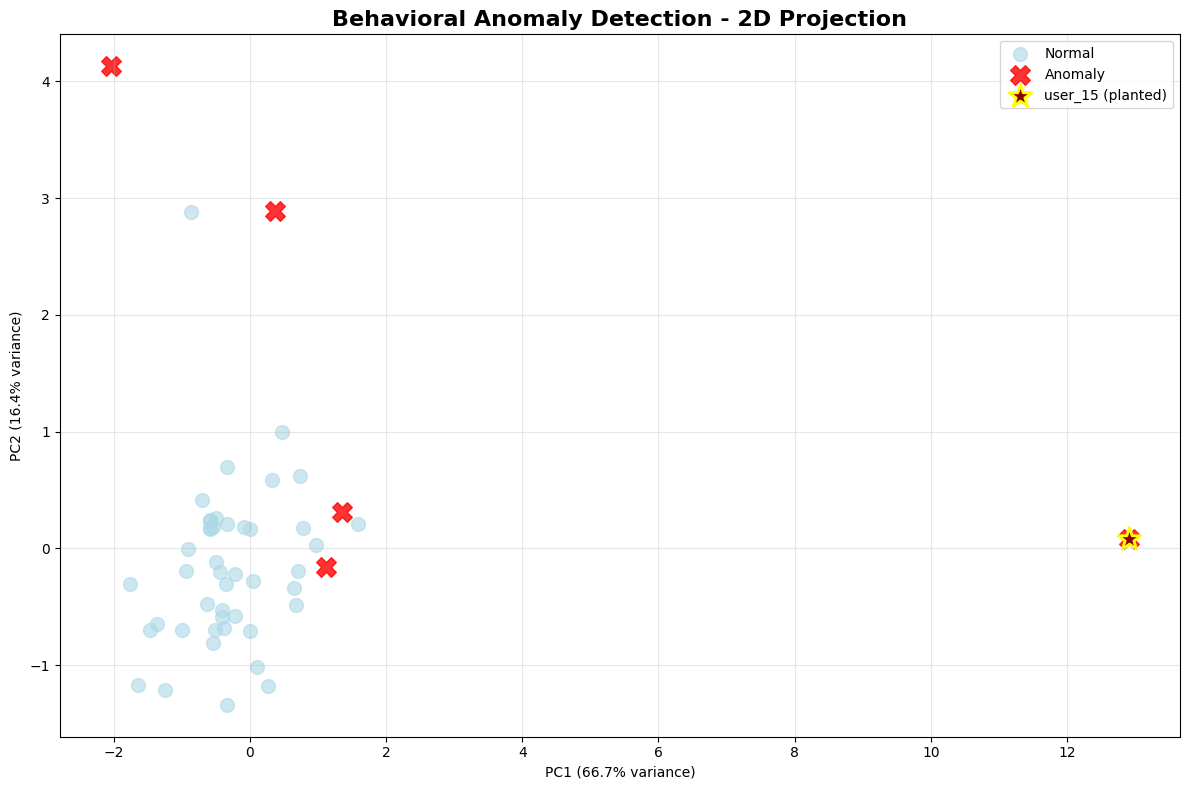

In [13]:
# Visualize anomalies in 2D space using PCA projection

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

features_df['pca1'] = X_pca[:, 0]
features_df['pca2'] = X_pca[:, 1]

plt.figure(figsize=(12, 8))
normal = features_df[features_df['anomaly_if'] == 1]
anomaly = features_df[features_df['anomaly_if'] == -1]

plt.scatter(normal['pca1'], normal['pca2'], c='lightblue', label='Normal', alpha=0.6, s=100)
plt.scatter(anomaly['pca1'], anomaly['pca2'], c='red', label='Anomaly', alpha=0.8, s=200, marker='X')

user_15_row = features_df[features_df['user_id'] == 'user_15']
plt.scatter(user_15_row['pca1'], user_15_row['pca2'], c='darkred', s=300, marker='*',
            edgecolors='yellow', linewidths=2, label='user_15 (planted)')

plt.title('Behavioral Anomaly Detection - 2D Projection', fontsize=16, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Simulate real-time monitoring of new blockchain events

def monitor_new_block(new_event, model, scaler, features_df):
    """Check if new blockchain event is anomalous"""

    user_id = new_event['user_id']

    new_features = features_df[features_df['user_id'] == user_id][feature_cols].values

    if len(new_features) == 0:
        return "New user - establishing baseline"

    new_features_scaled = scaler.transform(new_features)
    prediction = model.predict(new_features_scaled)[0]
    score = model.score_samples(new_features_scaled)[0]

    if prediction == -1:
        return f"ALERT: Anomalous behavior detected (score: {score:.3f})"
    else:
        return f"Normal behavior (score: {score:.3f})"

test_event = {'user_id': 'user_15', 'block_id': 999}
result = monitor_new_block(test_event, iso_forest, scaler, features_df)
print(f"Block #999 Analysis: {result}")

Block #999 Analysis: ALERT: Anomalous behavior detected (score: -0.853)


In [15]:
  # Summary of key takeaways and limitations

print("""
KEY TAKEAWAYS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

WHAT WE BUILT:
• Blockchain-verified event log analyzer
• Multi-model anomaly detection system
• Explainable behavioral features
• Real-time monitoring capability

MODEL COMPARISON:
• Isolation Forest: Best all-around, handles complex patterns
• LOF: Great for local density-based anomalies
• HBOS: Fastest, good for feature-wise outliers
• Elliptic Envelope: Works when data is Gaussian
• Robust PCA: Catches multi-dimensional anomalies
• CUSUM/EWMA: Sequential change detection for time-series

RED-HANDED REALITY:
"AI adds suspicion — not certainty."

LIMITATIONS:
1. False Positives: Legitimate power users may be flagged
2. Adversarial Evasion: Attackers can learn to mimic normal behavior
3. Cold Start: New users have no baseline
4. Feature Engineering: Requires domain expertise
5. Threshold Tuning: Contamination parameter needs calibration

PRODUCTION CONSIDERATIONS:
• Combine with rule-based systems (e.g., known attack patterns)
• Human-in-the-loop for final decisions
• Continuous retraining as behavior evolves
• Privacy: Ensure compliance with data regulations
• Explainability: Always provide reasons for alerts

NEXT STEPS:
• Add more features (geolocation, device fingerprints)
• Implement ensemble voting (combine multiple models)
• Build feedback loop (learn from false positives)
• Integrate with SIEM (Security Information and Event Management)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")


KEY TAKEAWAYS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

WHAT WE BUILT:
• Blockchain-verified event log analyzer
• Multi-model anomaly detection system
• Explainable behavioral features
• Real-time monitoring capability

MODEL COMPARISON:
• Isolation Forest: Best all-around, handles complex patterns
• LOF: Great for local density-based anomalies
• HBOS: Fastest, good for feature-wise outliers
• Elliptic Envelope: Works when data is Gaussian
• Robust PCA: Catches multi-dimensional anomalies
• CUSUM/EWMA: Sequential change detection for time-series

RED-HANDED REALITY:
"AI adds suspicion — not certainty."

LIMITATIONS:
1. False Positives: Legitimate power users may be flagged
2. Adversarial Evasion: Attackers can learn to mimic normal behavior
3. Cold Start: New users have no baseline
4. Feature Engineering: Requires domain expertise
5. Threshold Tuning: Contamination parameter needs calibration

PRODUCTION CONSIDERATIONS:
• Combine with rule-based systems